# Ablation: Semi-Supervised Architope - for Reviews
---
- This code Implements Algorithm 3.2 of the "PC-NNs" paper.

#### Mode: Code-Testin Parameter(s)

In [1]:
trial_run = True

### Meta-parameters

In [2]:
# Test-size Ratio
test_size_ratio = 1-(1/24)
min_width = 500
min_epochs = 15; min_epochs_classifier = 150
# Ablation Finess
N_plot_finess = 3
# min_parts_threshold = .001; max_parts_threshold = 0.9
N_min_parts = 2; N_max_plots = 20
Tied_Neurons_Q = True
randomize_subpattern_construction = True
# Partition with Inputs (determine parts with domain) or outputs (determine parts with image)
Partition_using_Inputs = True
# Cuttoff Level
gamma = .5
# Softmax Layer instead of sigmoid
softmax_layer = False #<- Just out of curiosity...but it doesn't perform many better IRL

In [3]:
#------------------------------------#
# Only For Motivational Example Only #
#------------------------------------#
## Hyperparameters
percentage_in_row = .25
N = 10**4

def f_1(x):
    return 1 + np.sin(10*x)
def f_2(x):
    return -2 -np.exp(x)
x_0 = 0
x_end = 1
import seaborn as sns

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [4]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready
1
Training Data size:  416


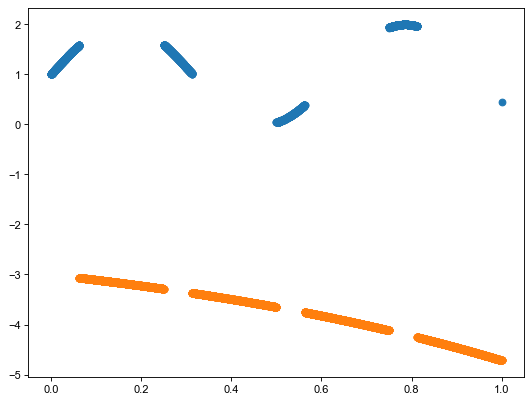

In [5]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Pre-process Data
if Option_Function != "Motivational_Example": 
    exec(open('Financial_Data_Preprocessor.py').read())
else:
    print(1)
    exec(open('Motivational_Example.py').read())
    print("Training Data size: ",X_train.shape[0])
# exec(open('Prepare_Data_California_Housing.py').read())
# Import time separately
import time

# TEMP
# import pickle_compat
# pickle_compat.patch()
# param_grid_Vanilla_Nets['input_dim']=X_train.shape[1]
sns.set()
plt.show()


### Set Seed

In [6]:
random.seed(2021)
tf.random.set_seed(2021)

#### Pre-Process:
- Convert Categorical Variables to Dummies
- Remove Bad Column
- Perform Training/Test Split

# Random Lipschitz Partition Builder

We implement the random paritioning method of [Yair Bartal](https://scholar.google.com/citations?user=eCXP24kAAAAJ&hl=en):
- [On approximating arbitrary metrices by tree metrics](https://dl.acm.org/doi/10.1145/276698.276725)

The algorithm is summarized as follow:

---

## Algorithm:
 1. Sample $\alpha \in [4^{-1},2^{-1}]$ randomly and uniformly,
 2. Apply a random suffle of the data, (a random bijection $\pi:\{i\}_{i=1}^X \rightarrow \mathbb{X}$),
 3. For $i = 1,\dots,I$:
   - Set $K_i\triangleq B\left(\pi(i),\alpha \Delta \right) - \bigcup_{j=1}^{i-1} P_j$
 
 4. Remove empty members of $\left\{K_i\right\}_{i=1}^X$.  
 
 **Return**: $\left\{K_i\right\}_{i=1}^{\tilde{X}}$.  
 
 For more details on the random-Lipschitz partition of Yair Bartal, see this [well-written blog post](https://nickhar.wordpress.com/2012/03/26/lecture-22-random-partitions-of-metric-spaces/).

## Define Random Partition Builder

#### Explicit Partion Builder:
Implements exactly Algorithm 2:

In [7]:
def Random_Lipschitz_Partioner(X_in,
                               y_in,
                               N_parts_to_get=4):

    # Compute Size of each part
    size_part_reference = int(round(X_in.shape[0]/N_parts_to_get))

    # Apply random bijection #
    #------------------------#
    ## Get random bijection indices
    random_bijection_indices = np.random.choice(range(X_in.shape[0]),size=X_in.shape[0], replace=False)
    ## Apply random bijections
    X_in_shuffled = X_in[random_bijection_indices,:]
    y_in_shuffled = y_in[random_bijection_indices,:]

    # Initialize Lists #
    #------------------#
    X_parts = []
    y_parts = []

    for i_th_part_to_get in range(N_parts_to_get):
        # Build random balls #
        #--------------------#
        ## Sample random radius
        size_part = int(np.maximum(1,np.round(size_part_reference*np.random.uniform(low=.5,high=1.5,size=1)[0])))
        ## Sample random point
        X_center_loop_index = np.random.choice(range(X_in_shuffled.shape[0]),size=1, replace=False)
        X_center_loop = X_in_shuffled[X_center_loop_index,:]
        ## Compute Typical Distances from Center
        distances_loop = X_center_loop-X_in_shuffled
        distances_loop = np.linalg.norm(distances_loop, axis=1)

        # Remove Random Ball from Dataset
        if size_part <= len(distances_loop):
            ## Identify indices
            indices_smallest_to_random_ball = np.argsort(distances_loop)[:size_part]
        else:
            print('Final Loop')
            indices_smallest_to_random_ball = np.array(range(X_in_shuffled.shape[0]))
        ## Extract Parts
        X_current_part_loop = X_in_shuffled[indices_smallest_to_random_ball,:]
        y_current_part_loop = y_in_shuffled[indices_smallest_to_random_ball,:]
        ## Append to List of Parts
        X_parts.append(X_current_part_loop)
        y_parts.append(y_current_part_loop)

        # Remove Selected Entries From Array #
        #------------------------------------#
        X_in_shuffled = np.delete(X_in_shuffled,indices_smallest_to_random_ball,axis=0)
        y_in_shuffled = np.delete(y_in_shuffled,indices_smallest_to_random_ball,axis=0)

        # Failsafe if procedure has terminated
        if X_in_shuffled.shape[0] == 0:
            print('breaking early')
            break
    # Count Number of Parts Generated        
    N_parts_generated = len(X_parts)
    # Output Parts
    return X_parts, y_parts, N_parts_generated

# Ablation Function

In [8]:
def get_PCNNs(N_parts,
              X_train,
              y_train,
              X_test,
              y_test):

    # Initialization(s) #
    #-------------------#
    N_neurons = 0
    L_timer = 0
    P_timer = 0
    Mean_Width_Subnetworks = 0

    # Partitioner Begin #
    #-------------------#
    import time
    partitioning_time_begin = time.time()
    print('-------------------------------------------------------')
    print('Randomly Initialized Parts - Via Randomized Algorithm 2')
    print('-------------------------------------------------------')
    if Partition_using_Inputs == True:
        X_parts_list, y_parts_list, N_parts_Generated_by_Algo_2 = Random_Lipschitz_Partioner(X_train.to_numpy(),
                                                                                             y_train.reshape(-1,1),
                                                                                             N_parts)
    else:
        X_parts_list, y_parts_list, N_parts_Generated_by_Algo_2 = Random_Lipschitz_Partioner(y_train.reshape(-1,1),
                                                                                             X_train.to_numpy(),
                                                                                             N_parts)
    partitioning_time = time.time() - partitioning_time_begin
    print('The_parts_listhe number of parts are: ' + str(N_parts_Generated_by_Algo_2)+'.')
    ############# Partitioner End ########

    print('-----------------------------------------------------')
    print('Training Sub-Networks on Each Randomly Generated Part')
    print('-----------------------------------------------------')
    # Time-Elapse (Start) for Training on Each Part #
    PCNN_timer = time.time(); PCNN_timer = -math.inf; N_params_Architope = 0; N_params_tally = 0
    # Remove Eager Execution Error(s)
    tf.compat.v1.disable_eager_execution()
    # Automatically Initialize Correct Input/Output Dimension(s)
    param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]; param_grid_Vanilla_Nets['output_dim'] = [1]
    param_grid_Deep_Classifier['input_dim'] = [X_train.shape[1]]
    # Decide if/or not to tie neuron numbers of sub-patterns together
    if Tied_Neurons_Q == True:
        param_grid_Vanilla_Nets['height'] = [int(np.maximum(round(param_grid_Vanilla_Nets['height'][0]/N_parts),min_width))]
        param_grid_Vanilla_Nets['epochs'] = [int(np.maximum(round(param_grid_Vanilla_Nets['epochs'][0]/int(round(np.sqrt(N_parts)))),min_epochs))]
#         param_grid_Deep_Classifier['height'] = [int(np.maximum(round(param_grid_Deep_Classifier['height'][0]/N_parts),min_width))]


    for current_part in range(N_parts_Generated_by_Algo_2):
        # Update User #
        #-------------#
        print('-----------------------------------------------------------')
        print('Currently Training Part: '+str(current_part)+'/'+str(N_parts_Generated_by_Algo_2 )+'Total Parts.')
        print('-----------------------------------------------------------')

        # Timer for Part
        part_training_timer = time.time()
        # Get Data for Sub-Pattern
        X_loop = pd.DataFrame(X_parts_list[current_part])
        y_loop = (y_parts_list[current_part]).reshape(-1,)
        # Train ffNN
        if randomize_subpattern_construction == False:
            y_hat_part_loop, y_hat_part_loop_test, N_neurons_PCNN_loop = build_ffNN(n_folds = 4, 
                                                                                  n_jobs = n_jobs,
                                                                                  n_iter = n_iter, 
                                                                                  param_grid_in = param_grid_Vanilla_Nets, 
                                                                                  X_train= X_loop, 
                                                                                  y_train=y_loop,
                                                                                  X_test_partial=X_train,
                                                                                  X_test=X_test,
                                                                                  NOCV=True)
        else:
            print('Randomized Predictions')
            y_hat_part_loop, y_hat_part_loop_test, N_neurons_PCNN_loop = build_ffNN_random(X_loop,
                                                                                           X_train,
                                                                                           X_test,
                                                                                           y_loop,
                                                                                           param_grid_Vanilla_Nets)
        # Reshape y
        ## Training
        y_train.shape = (y_train.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_part_loop.shape = (y_hat_part_loop.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        ## Testing
        y_test.shape = (y_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_part_loop_test.shape = (y_hat_part_loop_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])

        # Append predictions to data-frames
        ## If first prediction we initialize data-frames
        if current_part==0:
            # Register quality
            print('current_part: ',current_part)
            print(y_hat_part_loop.shape)
            print(y_train.shape)
            training_quality = np.array(np.abs(y_hat_part_loop-y_train)).reshape(y_hat_part_loop.shape[0],1)

            print('TQAL')
            print(training_quality.shape)
            # Save Predictions
            predictions_train = y_hat_part_loop.reshape(y_hat_part_loop.shape[0],1)
            predictions_test = y_hat_part_loop_test.reshape(y_hat_part_loop_test.shape[0],1)


        ## If not first prediction we append to already initialized dataframes
        else:
            print('current_part: ',current_part)
            print(y_hat_part_loop.shape)
            print('TQAL-else')
            print(training_quality.shape)
        # Register Best Scores
            #----------------------#
            # Write Predictions 
            # Save Predictions
            y_hat_train_loop = y_hat_part_loop.reshape(predictions_train.shape[0],1)
            predictions_train = np.append(predictions_train,y_hat_train_loop,axis=1)
            y_hat_test_loop = y_hat_part_loop_test.reshape(predictions_test.shape[0],1)
            predictions_test = np.append(predictions_test,y_hat_test_loop,axis=1)

            # Evaluate Errors #
            #-----------------#
            # Training
            prediction_errors = np.abs(y_hat_train_loop-y_train)
#             prediction_errors = np.abs(y_hat_train_loop-y_loop)
            training_quality = np.append(training_quality,prediction_errors.reshape(training_quality.shape[0],1),axis=1)

        print('training_quality')
        print(training_quality.shape)
        #==============================#
        # Update Performance Metric(s) #
        #==============================#
        part_training_timer = time.time() - part_training_timer
        # L-Time
        L_timer += partitioning_time
        # P-Time
        P_timer = max(P_timer,part_training_timer)
        # N. Params
        N_neurons += N_neurons_PCNN_loop
        # Mean Width for Sub-Network(s)
        Mean_Width_Subnetworks += param_grid_Vanilla_Nets['height'][0]

    # Take Mean of Width(s)
    Mean_Width_Subnetworks = Mean_Width_Subnetworks/N_parts_Generated_by_Algo_2
    print('-----------------------')
    print('Training Deep Zero-Sets')
    print('-----------------------')


    # Time Elapsed for Training Deep Zero-Sets
    Deep_Zero_Sets_timer = time.time()

    ## Initialize Classes Labels
    if softmax_layer == False:
        # No pooling (classical)
        partition_labels_training_integers = np.argmin(training_quality,axis=-1)
    else:
        # Max Pooling
#         partition_labels_training_integers = (training_quality == training_quality.min(axis=1)[:,None]).astype(int)
        partition_labels_training_integers = np.apply_along_axis(softminn, 1, training_quality).astype(int)
    partition_labels_training = pd.DataFrame(pd.DataFrame(partition_labels_training_integers) == 0)
    ## Build Classes
    for part_column_i in range(1,(training_quality.shape[1])):
        partition_labels_training = pd.concat([partition_labels_training,
                                               (pd.DataFrame(partition_labels_training_integers) == part_column_i)
                                              ],axis=1)
    ## Convert to integers
    partition_labels_training = partition_labels_training+0
    ## Train simple deep classifier
    tf.compat.v1.disable_eager_execution()
    exec(open('Grid_Enhanced_Network.py').read())
    if randomize_subpattern_construction == False:
#         print(partition_labels_training)
        param_grid_Deep_Classifier['epochs'] = [int(np.maximum(round(param_grid_Deep_Classifier['epochs'][0]),min_epochs_classifier))]
#         print(param_grid_Deep_Classifier)
        predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                            n_jobs = n_jobs, 
                                                                                                            n_iter =n_iter, 
                                                                                                            param_grid_in = param_grid_Deep_Classifier, 
                                                                                                            X_train = X_train.values, 
                                                                                                            y_train = partition_labels_training.values,
                                                                                                            X_test = X_test.values)
        # Get Binary Classes (Discontinuous Unit)
        ## Training Set
        predicted_classes_train = ((predicted_classes_train>gamma)*1).astype(int)
        ## Testing Set
        predicted_classes_test = ((predicted_classes_test > gamma)*1).astype(int)
        # Get PC-NN Prediction(s)
        ## Train
        PCNN_prediction_y_train = (predictions_train*predicted_classes_train).sum(axis=1)
        ## Test
        PCNN_prediction_y_test = (predictions_test*predicted_classes_test).sum(axis=1)
    else:
        print(X_train.shape)
        print(X_test.shape)
        print(predictions_test.shape)
        print(predictions_train.shape)
        print(partition_labels_training.shape)
        print(param_grid_Deep_Classifier)
        if N_parts > 1:
            print(partition_labels_training)
            partition_labels_training_dzs = np.argmin(partition_labels_training.to_numpy(),axis=-1)
            for j in range(10):
                print('---')
            print(partition_labels_training_dzs)
            PCNN_prediction_y_train, PCNN_prediction_y_test, N_params_deep_classifier = build_deep_classifier_random(X_train_in = X_train,
                                                                                                                     X_train_in_full = X_train,
                                                                                                                     X_test_in = X_test,
                                                                                                                     predictions_test_in = predictions_test,
                                                                                                                     predictions_train_in = predictions_train,
                                                                                                                     classes_in = partition_labels_training_dzs,
                                                                                                                     param_grid_in = param_grid_Deep_Classifier)
        else:
            PCNN_prediction_y_train = predictions_train.reshape(-1,param_grid_Vanilla_Nets['output_dim'][0])
            PCNN_prediction_y_test = predictions_test.reshape(-1,param_grid_Vanilla_Nets['output_dim'][0])
            N_params_deep_classifier = 0

    print('OK!')
    # End Timer
    Deep_Zero_Sets_timer = time.time() - Deep_Zero_Sets_timer

    print('-----------------------------------')
    print('Computing Final Performance Metrics')
    print('-----------------------------------')
    # Time-Elapsed Training Deep Classifier

    # Update Times
    L_timer +=Deep_Zero_Sets_timer
    P_timer +=Deep_Zero_Sets_timer
    # Update Number of Neurons Used
    N_neurons_subPatterns = N_neurons
    N_neurons_deep_Zero_Sets = (param_grid_Deep_Classifier['height'][0])*(param_grid_Deep_Classifier['depth'][0])
    N_neurons = N_neurons_deep_Zero_Sets + N_neurons_subPatterns



    # Compute Peformance
    performance_PCNN = reporter(y_train_hat_in=PCNN_prediction_y_train,y_test_hat_in=PCNN_prediction_y_test,
                                y_train_in=y_train,
                                y_test_in=y_test)
    # Write Performance
    performance_PCNN.to_latex((results_tables_path+"PCNN_full_performance.tex"))

    # Update User
    print(performance_PCNN)

    ### Model Complexity/Efficiency Metrics
    # Build AIC-like Metric #
    #-----------------------#
    AIC_like = 2*(N_neurons - np.log((performance_PCNN['test']['MAE'])))
    AIC_like = np.round(AIC_like,3)
    Efficiency = np.log(N_neurons) *(performance_PCNN['test']['MAE'])
    Efficiency = np.round(Efficiency,3)


    # Build Table #
    #-------------#
    PCNN_Model_Complexity = pd.DataFrame({'L-time': [L_timer],
                                               'P-time':[P_timer],
                                               'N_params_expt': [N_neurons],
                                               'AIC-like': [AIC_like],
                                               'Eff': [Efficiency],
                                               'N. Parts':[N_parts_Generated_by_Algo_2]})


    # Write Required Training Time(s)
    PCNN_Model_Complexity.to_latex((results_tables_path+"PCNN_full_model_complexities.tex"))

    #--------------======---------------#
    # Display Required Training Time(s) #
    #--------------======---------------#
    print(PCNN_Model_Complexity)
    
    
    
    #########################################
    for j in range(10):
        print('#------------------------------#')
    #########################################
    print('# ---- Getting Benchmarks ---- #')
    #########################################
    for j in range(10):
        print('#------------------------------#')
    #########################################
    print('Training PCNN-lgt')
    # Time-Elapsed Training linear classifier
    Architope_logistic_classifier_training_begin = time.time()
    print('N parts: ',N_parts)
    if N_parts > 1:
        parameters = {'penalty': ['none'], 'C': [0.1]}
        lr = LogisticRegression(random_state=2020)
        cv = RepeatedStratifiedKFold(n_splits=CV_folds, 
                                     n_repeats=n_iter, random_state=0)
        classifier = RandomizedSearchCV(lr, 
                                        parameters, 
                                        random_state=2020)

        # Initialize Classes Labels
        partition_labels_training = np.argmin(training_quality,axis=-1)
        # Train Logistic Classifier #
        #---------------------------#
        # Supress warnings caused by "ignoring C" for 'none' penalty and similar obvious warnings
        warnings.simplefilter("ignore")
        # Train Classifier
        classifier.fit(X_train, partition_labels_training)
    if N_parts >1 :
        #### Write Predicted Class(es)
        # Training Set
        predicted_classes_train_logistic_BM = classifier.best_estimator_.predict(X_train)
        Architope_prediction_y_train_logistic_BM = np.take_along_axis(predictions_train, predicted_classes_train_logistic_BM[:,None], axis=1)
        # Testing Set
        predicted_classes_test_logistic_BM = classifier.best_estimator_.predict(X_test)
        Architope_prediction_y_test_logistic_BM = np.take_along_axis(predictions_test, 
                                                                     predicted_classes_test_logistic_BM[:,None], 
                                                                     axis=1)
    else:
        #### Write Predicted Class(es)
        # Training Set
        Architope_prediction_y_train_logistic_BM = predictions_train
        # Testing Set
        Architope_prediction_y_test_logistic_BM = predictions_test    
    # Extract Number of Parameters Logistic Regressor
    if N_parts > 1:
        N_params_best_logistic = (classifier.best_estimator_.coef_.shape[0])*(classifier.best_estimator_.coef_.shape[1]) + len(classifier.best_estimator_.intercept_)
    else:
        N_params_best_logistic = 1
    N_params_best_logistic = N_params_best_logistic + N_neurons_subPatterns*N_parts    
    # Time-Elapsed Training linear classifier
    Architope_logistic_classifier_training = time.time() - Architope_logistic_classifier_training_begin
    #### Compute Performance
    # Compute Peformance
    performance_architope_ffNN_logistic = reporter(y_train_hat_in=Architope_prediction_y_train_logistic_BM,
                                        y_test_hat_in=Architope_prediction_y_test_logistic_BM,
                                        y_train_in=y_train,
                                        y_test_in=y_test)
    # Write Performance
    performance_architope_ffNN_logistic.to_latex((results_tables_path+"Architopes_logistic_performance.tex"))
    
    ##### --- #####
    print('Training PCNN-Bagged')
    ##### --- #####
    # Time for Bagging
    Bagging_ffNN_bagging_time_begin = time.time()
    # Train Bagging Weights in-sample
    bagging_coefficients = LinearRegression().fit(predictions_train,y_train)
    # Predict Bagging Weights out-of-sample
    bagged_prediction_train = bagging_coefficients.predict(predictions_train)
    bagged_prediction_test = bagging_coefficients.predict(predictions_test)
    # Write number of trainable bagging parameters
    N_bagged_parameters = len(bagging_coefficients.coef_) + 1
    # Time for Bagging
    Bagging_ffNN_bagging_time = time.time() - Bagging_ffNN_bagging_time_begin
    # Compute Peformance
    performance_bagged_ffNN = reporter(y_train_hat_in=bagged_prediction_train,
                                        y_test_hat_in=bagged_prediction_test,
                                        y_train_in=y_train,
                                        y_test_in=y_test)
    # Write Performance
    performance_bagged_ffNN.to_latex((results_tables_path+"ffNN_Bagged.tex"))
    
    for jj in range(5):
        print('-----------------------')
    print('...Returning Results...')
    for jj in range(5):
        print('-----------------------')
    # Return Output(s)
    return performance_PCNN, PCNN_Model_Complexity, N_parts_Generated_by_Algo_2, N_neurons, N_neurons_subPatterns,N_neurons_deep_Zero_Sets, Mean_Width_Subnetworks, performance_architope_ffNN_logistic, N_params_best_logistic, performance_bagged_ffNN, Bagging_ffNN_bagging_time, Architope_logistic_classifier_training, Deep_Zero_Sets_timer

---
# Perform Ablation:
---

In [9]:
# Initialize 
# q_implicit_N_parts_possibilities = np.linspace(min_parts_threshold,max_parts_threshold,N_plot_finess)
# Sequential # of Parts:
N_parts_possibilities = np.unique(np.round(np.linspace(N_min_parts,N_max_plots,num=N_plot_finess))).astype(int)
# Custom # of Parts: # N_parts_possibilities = np.array([1,20,50]); N_plot_finess = len(N_parts_possibilities)

# Get Performance Metric
for inplicit_N_parts_loop in range(len(N_parts_possibilities)):
    ### UPDATE USER ###
    for k in range(10):
        print('--------------------------------------')
    print('Ablation Completion Percentage:',(inplicit_N_parts_loop/N_plot_finess))
    for k in range(10):
        print('--------------------------------------')
    
    # Implicitly Set: Current Number of Parts
#     q_implicit_N_parts_loop = q_implicit_N_parts_possibilities[inplicit_N_parts_loop]
    N_parts_possibilities_loop = N_parts_possibilities[inplicit_N_parts_loop]
    # Run Algos. 1+2
    performance_Architope_loop, Architope_Model_Complexity_full_loop, N_parts_Generated_by_Algo_2_loop, N_params_architope_loop, N_neurons_subPatterns_loop, N_neurons_deep_Zero_Sets_loop, height_mean_loop, performance_PCNN_ffNN_logistic_loop, N_params_PCNN_logistic_loop,performance_bagged_ffNN_loop, baggin_time_loop, logistic_time_loop, Deep_Zero_Sets_timer_loop = get_PCNNs(N_parts_possibilities_loop,X_train,y_train,X_test,y_test)
    # Reshape
    performance_Architope_loop = performance_Architope_loop.to_numpy().reshape([3,2,1])
    Architope_Model_Complexity_full_loop = Architope_Model_Complexity_full_loop.to_numpy().reshape([1,6,1])
    performance_PCNN_ffNN_logistic_loop = performance_PCNN_ffNN_logistic_loop.to_numpy().reshape([3,2,1])
    performance_bagged_ffNN_loop = performance_bagged_ffNN_loop.to_numpy().reshape([3,2,1])
    # Record
    if inplicit_N_parts_loop == 0:
        # Don't count partitioner if only one parts is active!
        if N_parts_possibilities_loop <= 1:
            Architope_Model_Complexity_full_loop[:,1] = Architope_Model_Complexity_full_loop[:,0]
            N_neurons_deep_Zero_Sets_loop = 0
        # Record Model Complexities Otherwise    
        performance_Architope_history = performance_Architope_loop
        Architope_Model_Complexity_history = Architope_Model_Complexity_full_loop
        N_parts_Generated_by_Algo_2_history = N_parts_Generated_by_Algo_2_loop
        N_params_subPatterns_hist = N_neurons_subPatterns_loop
        N_neurons_deep_Zero_Sets_hist = N_neurons_deep_Zero_Sets_loop
        N_params_architope_hist = N_neurons_deep_Zero_Sets_loop + N_neurons_subPatterns_loop
        height_mean_hist = height_mean_loop
        N_neurons_per_input = N_neurons_deep_Zero_Sets_loop + int(round(N_neurons_subPatterns_loop/N_parts_possibilities_loop))
        ### BENCHMARKs
        ### Logistic PCNN
        performance_PCNN_ffNN_logistic_hist = performance_PCNN_ffNN_logistic_loop
        N_params_PCNN_logistic_hist = N_params_PCNN_logistic_loop
        logistic_time_hist =  logistic_time_loop
        baggin_time_hist = baggin_time_loop
        ### Bagged PCNNs
        performance_bagged_ffNN_hist = performance_bagged_ffNN_loop
        ### Misc
        Deep_Zero_Sets_timer_hist = Deep_Zero_Sets_timer_loop
    else:
        performance_Architope_history = np.concatenate((performance_Architope_history,performance_Architope_loop),axis=2)
        Architope_Model_Complexity_history = np.concatenate((Architope_Model_Complexity_history,Architope_Model_Complexity_full_loop),axis=2)
        N_parts_Generated_by_Algo_2_history = np.append(N_parts_Generated_by_Algo_2_history,N_parts_Generated_by_Algo_2_loop)
        N_params_architope_hist = np.append(N_params_architope_hist,N_params_architope_loop)
        N_params_subPatterns_hist = np.append(N_params_subPatterns_hist,N_neurons_subPatterns_loop)
        N_neurons_deep_Zero_Sets_hist = np.append(N_neurons_deep_Zero_Sets_hist,N_neurons_deep_Zero_Sets_loop)
        height_mean_hist = np.append(height_mean_hist,height_mean_loop)
        N_neurons_per_input = np.append(N_neurons_per_input,(N_neurons_deep_Zero_Sets_loop + int(round(N_neurons_subPatterns_loop/N_parts_possibilities_loop))))
        ### Logistic PCNN
        performance_PCNN_ffNN_logistic_hist = np.concatenate((performance_PCNN_ffNN_logistic_hist,
                                                              performance_PCNN_ffNN_logistic_loop),
                                                             axis=2)
        N_params_PCNN_logistic_hist = np.append(N_params_PCNN_logistic_hist,N_params_PCNN_logistic_loop)
        logistic_time_hist = np.append(logistic_time_hist,logistic_time_loop)
        ### Bagged Performance
        performance_bagged_ffNN_hist = np.concatenate((performance_bagged_ffNN_hist,
                                                       performance_bagged_ffNN_loop),
                                                      axis=2)
        baggin_time_hist = np.append(baggin_time_hist,baggin_time_loop)
        ### Misc
        Deep_Zero_Sets_timer_hist = np.append(Deep_Zero_Sets_timer_hist,Deep_Zero_Sets_timer_loop)

--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
Ablation Completion Percentage: 0.0
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
-------------------------------------------------------
Randomly Initialized Parts - Via Randomized Algorithm 2
-------------------------------------------------------
The_parts_listhe

current_part:  10
(416, 1)
TQAL-else
(416, 10)
training_quality
(416, 11)
-----------------------
Training Deep Zero-Sets
-----------------------
(416, 1)
(9585, 1)
(9585, 11)
(416, 11)
(416, 11)
{'batch_size': [16], 'epochs': [200], 'learning_rate': [0.0001], 'height': [400], 'depth': [2], 'input_dim': [1], 'output_dim': [1]}
     0  0  0  0  0  0  0  0  0  0  0
0    0  0  1  0  0  0  0  0  0  0  0
1    0  0  0  0  1  0  0  0  0  0  0
2    0  0  1  0  0  0  0  0  0  0  0
3    0  0  1  0  0  0  0  0  0  0  0
4    0  0  0  0  0  0  0  1  0  0  0
..  .. .. .. .. .. .. .. .. .. .. ..
411  0  0  1  0  0  0  0  0  0  0  0
412  0  0  1  0  0  0  0  0  0  0  0
413  0  0  1  0  0  0  0  0  0  0  0
414  0  1  0  0  0  0  0  0  0  0  0
415  0  0  0  0  0  0  0  0  1  0  0

[416 rows x 11 columns]
---
---
---
---
---
---
---
---
---
---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0

current_part:  16
(416, 1)
TQAL-else
(416, 16)
training_quality
(416, 17)
-----------------------------------------------------------
Currently Training Part: 17/20Total Parts.
-----------------------------------------------------------
Randomized Predictions
current_part:  17
(416, 1)
TQAL-else
(416, 17)
training_quality
(416, 18)
-----------------------------------------------------------
Currently Training Part: 18/20Total Parts.
-----------------------------------------------------------
Randomized Predictions
current_part:  18
(416, 1)
TQAL-else
(416, 18)
training_quality
(416, 19)
-----------------------------------------------------------
Currently Training Part: 19/20Total Parts.
-----------------------------------------------------------
Randomized Predictions
current_part:  19
(416, 1)
TQAL-else
(416, 19)
training_quality
(416, 20)
-----------------------
Training Deep Zero-Sets
-----------------------
(416, 1)
(9585, 1)
(9585, 20)
(416, 20)
(416, 20)
{'batch_size': [16], 'ep

In [10]:
# Cleanup
## Randomization may produce duplicates; we remove these with the following snippet:
get_unique_entries = np.unique(N_parts_Generated_by_Algo_2_history, return_index=True)[1]
N_parts_Generated_by_Algo_2_history_report = N_parts_Generated_by_Algo_2_history[get_unique_entries]

# Write
## Prediction Qualities
performance_Architope_history_report_MAE_train = (performance_Architope_history[0,0,:])[get_unique_entries]
performance_Architope_history_report_MAE_test = (performance_Architope_history[0,1,:])[get_unique_entries]
performance_Architope_history_report_MSE_train = (performance_Architope_history[1,0,:])[get_unique_entries]
performance_Architope_history_report_MSE_test = (performance_Architope_history[1,1,:])[get_unique_entries]
## Model Complexities
L_Times = (Architope_Model_Complexity_history[:,1].reshape(-1,))[get_unique_entries]
P_Times = (Architope_Model_Complexity_history[:,0].reshape(-1,))[get_unique_entries]
N_Params = (N_params_architope_hist.reshape(-1,))[get_unique_entries]
mean_subpattern_widths_hist = (height_mean_hist.reshape(-1,))[get_unique_entries]
AIC_Like = (Architope_Model_Complexity_history[:,3].reshape(-1,))[get_unique_entries]
Eff = (Architope_Model_Complexity_history[:,4].reshape(-1,))[get_unique_entries]
N_neurons_per_input = (N_neurons_per_input.reshape(-1,))[get_unique_entries]
## Misc
Deep_Zero_Sets_timer_hist = Deep_Zero_Sets_timer_hist[get_unique_entries]

# Record Benchmark Complexities
## PCNN-lgt
performance_lgt_ffNN_report_MAE_train = (performance_PCNN_ffNN_logistic_hist[0,0,:])[get_unique_entries]
performance_lgt_ffNN_report_MAE_test = (performance_PCNN_ffNN_logistic_hist[0,1,:])[get_unique_entries]
performance_lgt_ffNN_report_MSE_train = (performance_PCNN_ffNN_logistic_hist[1,0,:])[get_unique_entries]
performance_lgt_ffNN_report_MSE_test = (performance_PCNN_ffNN_logistic_hist[1,1,:])[get_unique_entries]
N_params_PCNN_logistic_hist = (N_params_subPatterns_hist + N_parts_Generated_by_Algo_2_history_report)[get_unique_entries]
N_params_PCNN_logistic_hist_per_input = N_parts_Generated_by_Algo_2_history_report + N_params_subPatterns_hist[get_unique_entries]
P_time_PCNN_lgt = logistic_time_hist[get_unique_entries] + P_Times - Deep_Zero_Sets_timer_hist
L_time_PCNN_lgt = logistic_time_hist[get_unique_entries] + L_Times - Deep_Zero_Sets_timer_hist
## PCNN-bag
performance_PCNN_ffNN_bag_report_MAE_train = (performance_bagged_ffNN_hist[0,0,:])[get_unique_entries]
performance_PCNN_ffNN_bag_report_MAE_test = (performance_bagged_ffNN_hist[0,1,:])[get_unique_entries]
performance_PCNN_ffNN_bag_report_MSE_train = (performance_bagged_ffNN_hist[1,0,:])[get_unique_entries]
performance_PCNN_ffNN_bag_report_MSE_test = (performance_bagged_ffNN_hist[1,1,:])[get_unique_entries]
N_params_PCNN_ffNN_bag = (N_params_subPatterns_hist*N_parts_Generated_by_Algo_2_history_report)[get_unique_entries]
N_params_PCNN_ffNN_bag_per_input = N_params_PCNN_ffNN_bag
P_time_PCNN_bag = baggin_time_hist[get_unique_entries] + P_Times - Deep_Zero_Sets_timer_hist
L_time_PCNN_bag = baggin_time_hist[get_unique_entries] + L_Times - Deep_Zero_Sets_timer_hist

---
# Get Best PCNN
This is identified as the PCNN with the smallest training MAE.

---

In [11]:
best_N_parts = 2#np.argmin(performance_Architope_history_report_MAE_test)
# Get PCNN Performance Metrics
PCNN_MAE_train = performance_Architope_history_report_MAE_train[best_N_parts]
PCNN_MAE_test = performance_Architope_history_report_MAE_test[best_N_parts]
PCNN_MSE_train = performance_Architope_history_report_MSE_train[best_N_parts]
PCNN_MSE_test = performance_Architope_history_report_MSE_test[best_N_parts]
PCNN_performance_all = performance_Architope_history[:,:,best_N_parts]
## Model Complexities
PCNN_L_time = L_Times[best_N_parts]
PCNN_P_time = P_Times[best_N_parts]
PCNN_subpattern_widths_hist = mean_subpattern_widths_hist[best_N_parts]
PCNN_AIC_Like = AIC_Like[best_N_parts]
PCNN_Eff = Eff[best_N_parts]
PCNN_N_neurons_per_input = N_neurons_per_input[best_N_parts]

---
# Get Other Benchmark(s)
## Feedforward Neural Network (ffNN) Benchmark
---

In [12]:
if randomize_subpattern_construction == True:
    exec(open('Grid_Enhanced_Network.py').read())
    ffNN_train_time = time.time()
    y_hat_ffNN_train, y_hat_ffNN_test, N_neurons_ffNN = build_ffNN(n_folds = 4, 
                                                                   n_jobs = n_jobs,
                                                                   n_iter = n_iter, 
                                                                   param_grid_in = param_grid_Vanilla_Nets, 
                                                                   X_train= X_train, 
                                                                   y_train=y_train,
                                                                   X_test_partial=X_train,
                                                                   X_test=X_test,
                                                                   NOCV=True)
    #### Compute Performance
    # Compute Peformance
    performance_ffNN = reporter(y_train_hat_in=y_hat_ffNN_train,
                                y_test_hat_in=y_hat_ffNN_test,
                                y_train_in=y_train,
                                y_test_in=y_test)
    P_time_ffNN = time.time() - ffNN_train_time
    L_time_ffNN = P_time_ffNN
    Width_ffNN = param_grid_Vanilla_Nets['height'][0]; Width_neurons_ffNN = Width_ffNN
    MAE_ffNN = np.repeat(performance_ffNN.to_numpy()[0,1],len(N_parts_Generated_by_Algo_2_history_report))
    MSE_ffNN = np.repeat(performance_ffNN.to_numpy()[1,1],len(N_parts_Generated_by_Algo_2_history_report))
    N_neurons_per_input_ffNN = np.repeat(N_neurons_ffNN,len(N_parts_Generated_by_Algo_2_history_report)); N_neurons_ffNN = N_neurons_per_input_ffNN
    # Misc
    ffNN_performance_all = performance_ffNN.to_numpy()
else:
    # Record Model complexities for ffNNs
    P_time_ffNN = P_Times[0]
    L_time_ffNN = P_Times[0]
    Width_ffNN = height_mean_hist[0]
    # For: Plots
    MAE_ffNN = np.repeat(performance_Architope_history_report_MAE_test[0],len(N_parts_Generated_by_Algo_2_history_report))
    MSE_ffNN = np.repeat(performance_Architope_history_report_MSE_test[0],len(N_parts_Generated_by_Algo_2_history_report))
    N_neurons_per_input_ffNN = np.repeat(N_neurons_per_input[0],len(N_parts_Generated_by_Algo_2_history_report))
    Width_neurons_ffNN = np.repeat(mean_subpattern_widths_hist[0],len(N_parts_Generated_by_Algo_2_history_report))
    N_neurons_ffNN = np.repeat(N_Params[0],len(N_parts_Generated_by_Algo_2_history_report))
    # Misc
    ffNN_performance_all = performance_Architope_history[:,:,0]
L_times_ffNN_plot = np.repeat(L_time_ffNN,len(N_parts_Generated_by_Algo_2_history_report))
P_times_ffNN_plot = np.repeat(P_time_ffNN,len(N_parts_Generated_by_Algo_2_history_report))
# Record in Table
ffNN_Model_Complexity = pd.DataFrame({'L-time': [L_time_ffNN],
                                               'P-time':[P_time_ffNN],
                                               'N_params_expt': [N_neurons_ffNN],
                                               'AIC-like': [0],
                                               'Eff': [0],
                                               'N. Parts':[1]})

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 416 samples
Epoch 1/200
416/416 [==============================] - 0s 721us/sample - loss: 2.0999 - mse: 6.6459 - mae: 2.0999 - mape: 168.3920
Epoch 2/200
416/416 [==============================] - 0s 91us/sample - loss: 1.3172 - mse: 5.0377 - mae: 1.3172 - mape: 202.7121
Epoch 3/200
416/416 [==============================] - 0s 102us/sample - loss: 1.2525 - mse: 5.0661 - mae: 1.2525 - mape: 203.8536
Epoch 4/200
416/416 [==============================] - 0s 93us/sample - loss: 1.1750 - mse: 5.2451 - mae: 1.1750 - mape: 206.4722
Epoch 5/200
416/416 [==============================] - 0s 86us/sample - loss: 1.1607 - mse: 5.3135 - mae: 1.1607 - mape: 207.6539
Epoch 6/200
416/416 [==============================] - 0s 88us/sample - loss: 1.1548 - mse: 5.2923 - mae: 1.1548 - mape: 206.3470
Epoch 7/200
416/416 [==============================] - 0s 96us/sample - loss: 1.1655 - mse: 5.2789 - mae: 1.1655 - m

416/416 [==============================] - 0s 98us/sample - loss: 1.1657 - mse: 5.2745 - mae: 1.1657 - mape: 206.6016
Epoch 61/200
416/416 [==============================] - 0s 97us/sample - loss: 1.1751 - mse: 5.3382 - mae: 1.1751 - mape: 208.2890
Epoch 62/200
416/416 [==============================] - 0s 86us/sample - loss: 1.1807 - mse: 5.3040 - mae: 1.1807 - mape: 206.4166
Epoch 63/200
416/416 [==============================] - 0s 85us/sample - loss: 1.1701 - mse: 5.3165 - mae: 1.1701 - mape: 207.1988
Epoch 64/200
416/416 [==============================] - 0s 95us/sample - loss: 1.1583 - mse: 5.3017 - mae: 1.1583 - mape: 207.0709
Epoch 65/200
416/416 [==============================] - 0s 94us/sample - loss: 1.1589 - mse: 5.2944 - mae: 1.1589 - mape: 206.1781
Epoch 66/200
416/416 [==============================] - 0s 84us/sample - loss: 1.1516 - mse: 5.3026 - mae: 1.1516 - mape: 206.3456
Epoch 67/200
416/416 [==============================] - 0s 84us/sample - loss: 1.1527 - mse: 5.3

416/416 [==============================] - 0s 94us/sample - loss: 1.2020 - mse: 5.3532 - mae: 1.2020 - mape: 209.9904
Epoch 123/200
416/416 [==============================] - 0s 92us/sample - loss: 1.1657 - mse: 5.2313 - mae: 1.1657 - mape: 205.4883
Epoch 124/200
416/416 [==============================] - 0s 87us/sample - loss: 1.1596 - mse: 5.3041 - mae: 1.1596 - mape: 206.6184
Epoch 125/200
416/416 [==============================] - 0s 82us/sample - loss: 1.1523 - mse: 5.3510 - mae: 1.1523 - mape: 206.7913
Epoch 126/200
416/416 [==============================] - 0s 91us/sample - loss: 1.1502 - mse: 5.3319 - mae: 1.1502 - mape: 207.2226
Epoch 127/200
416/416 [==============================] - 0s 86us/sample - loss: 1.1558 - mse: 5.3200 - mae: 1.1558 - mape: 206.6989
Epoch 128/200
416/416 [==============================] - 0s 85us/sample - loss: 1.1494 - mse: 5.2867 - mae: 1.1494 - mape: 205.8049
Epoch 129/200
416/416 [==============================] - 0s 88us/sample - loss: 1.1486 - m

416/416 [==============================] - 0s 93us/sample - loss: 1.1498 - mse: 5.3330 - mae: 1.1498 - mape: 206.4034
Epoch 185/200
416/416 [==============================] - 0s 95us/sample - loss: 1.1426 - mse: 5.3485 - mae: 1.1426 - mape: 206.7185
Epoch 186/200
416/416 [==============================] - 0s 90us/sample - loss: 1.1580 - mse: 5.3167 - mae: 1.1580 - mape: 206.7595
Epoch 187/200
416/416 [==============================] - 0s 101us/sample - loss: 1.1616 - mse: 5.3082 - mae: 1.1616 - mape: 206.7091
Epoch 188/200
416/416 [==============================] - 0s 88us/sample - loss: 1.1532 - mse: 5.3433 - mae: 1.1532 - mape: 206.6353
Epoch 189/200
416/416 [==============================] - 0s 88us/sample - loss: 1.1596 - mse: 5.2993 - mae: 1.1596 - mape: 206.6177
Epoch 190/200
416/416 [==============================] - 0s 100us/sample - loss: 1.1494 - mse: 5.3408 - mae: 1.1494 - mape: 206.6561
Epoch 191/200
416/416 [==============================] - 0s 90us/sample - loss: 1.1646 -

## Gradient Boosted Random Forest Regressor (GBRF)

In [13]:
# Update User #
#-------------#
print('Training Gradient-Boosted Random Forest: In-progress...')
# Run from External Script
exec(open('Gradient_Boosted_Random_Forest_Regressor.py').read())
# Update User #
#-------------#
print('Training of Gradient-Boosted Random Forest: Complete!')

Training Gradient-Boosted Random Forest: In-progress...
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Gradient Boosted Trees Model - Done CV!
Random Forest Regressor uses: 13740 parameters.
          train       test
MAE    0.407721   0.437993
MSE    0.240249   0.371069
MAPE  47.888754  48.102996
Training of Gradient-Boosted Random Forest: Complete!


# Write Tables

##### Write Required Training Times

In [14]:
# Update User #
#-------------#
print('Completing Table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'ffNN': [round(L_Times[0],3)],
                                       'GBRF': [round(Gradient_boosted_Random_forest_time,3)],
                                       'ffNN-Bag': [round(L_time_PCNN_bag[best_N_parts],3)],
                                       'ffNN-log': [round(L_time_PCNN_lgt[best_N_parts],3)],
                                       'PCNN': [round(PCNN_L_time,3)]
                                      },index=['In-Line (L-Time)'])

training_times_Parallel = pd.DataFrame({'ffNN': ['-'],
                                       'GBRF': ['-'],
                                       'ffNN-Bag': [round(L_time_PCNN_bag[best_N_parts],3)],
                                       'ffNN-log': [round(L_time_PCNN_lgt[best_N_parts],3)],
                                       'PCNN': [round(PCNN_L_time,3)]
                                      },index=['Parallel (P-Time)'])

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)
Model_Training_times = Model_Training_times.transpose()

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))

Completing Table: Required Training Times


### Prediction Metric(s)
#### Write Predictive Performance Dataframe(s)

In [15]:
# Write Training Performance
predictive_performance_training = pd.DataFrame({'ffNN': ffNN_performance_all[:,0],
                                                'GBRF': Gradient_boosted_tree.train,
                                                'ffNN-bag': performance_bagged_ffNN_hist[:,:,best_N_parts][:,0],
                                                'ffNN-lgt': performance_PCNN_ffNN_logistic_hist[:,:,best_N_parts][:,0],
                                                'PCNN': PCNN_performance_all[:,0]})
predictive_performance_training = predictive_performance_training.transpose()

# Write Testing Performance
predictive_performance_test = pd.DataFrame({'ffNN': ffNN_performance_all[:,1],
                                            'GBRF': Gradient_boosted_tree.test,
                                            'ffNN-bag': performance_bagged_ffNN_hist[:,:,best_N_parts][:,1],
                                            'ffNN-lgt': performance_PCNN_ffNN_logistic_hist[:,:,best_N_parts][:,1],
                                            'PCNN': PCNN_performance_all[:,1]})
predictive_performance_test = predictive_performance_test.transpose()

# Write into one Dataframe #
#--------------------------#
predictive_performance_training.to_latex((results_tables_path+"Models_predictive_performance_training.tex"))
predictive_performance_test.to_latex((results_tables_path+"Models_predictive_performance_testing.tex"))

---
## Plots
---

In [16]:
plt.show()

## MSE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


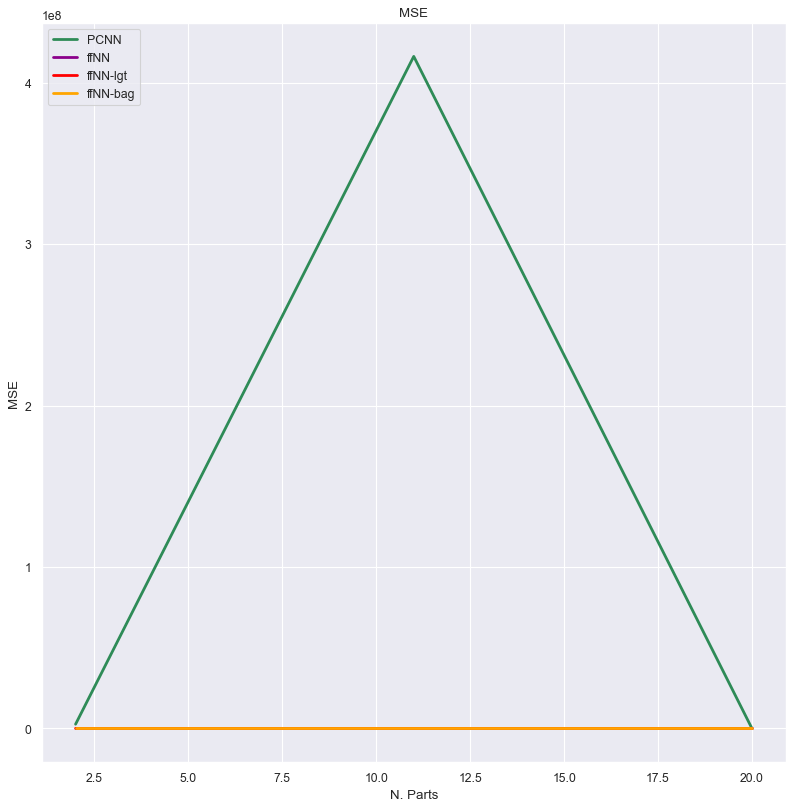

In [17]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("MSE")
plt.xlabel("N. Parts")
plt.ylabel("MSE")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_Architope_history_report_MSE_test,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         MSE_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_lgt_ffNN_report_MSE_test,
         label = 'ffNN-lgt',
         color='red',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_PCNN_ffNN_bag_report_MSE_test,
         label = 'ffNN-bag',
         color='orange',
         linewidth=2.5)
# Add Legend
plt.legend(loc="upper left")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_MSE_test___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

## MAE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


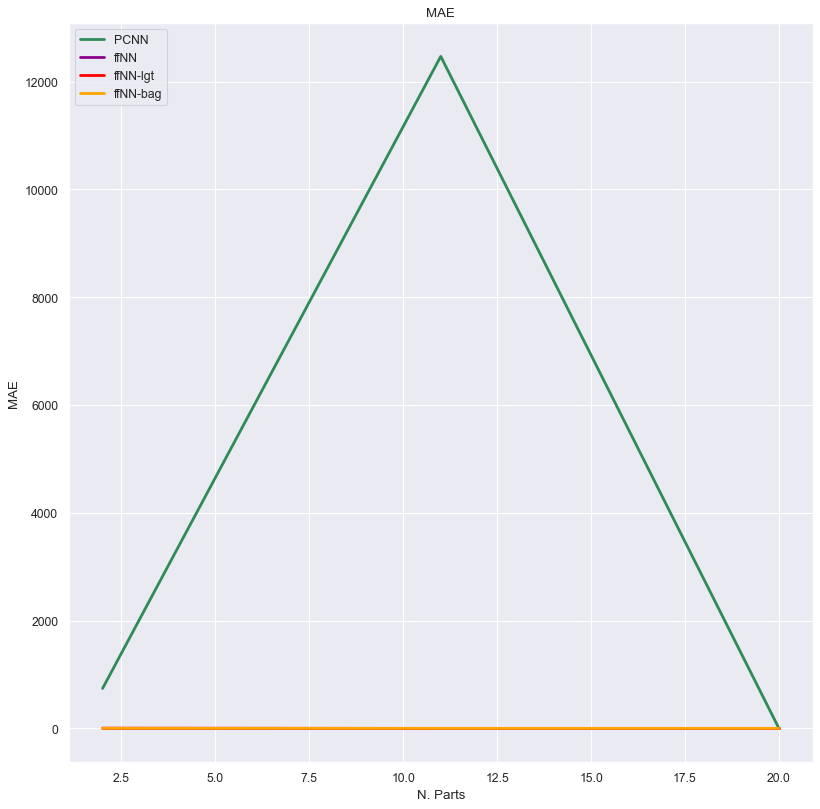

In [18]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("MAE")
plt.xlabel("N. Parts")
plt.ylabel("MAE")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_Architope_history_report_MAE_test,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         MAE_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_lgt_ffNN_report_MAE_test,
         label = 'ffNN-lgt',
         color='red',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_PCNN_ffNN_bag_report_MAE_test,
         label = 'ffNN-bag',
         color='orange',
         linewidth=2.5)

# Export #
#--------#
# SAVE Figure to .eps
plt.legend(loc="upper left")
plt.savefig('./outputs/plotsANDfigures/Ablation_MAE___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# L-Time

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


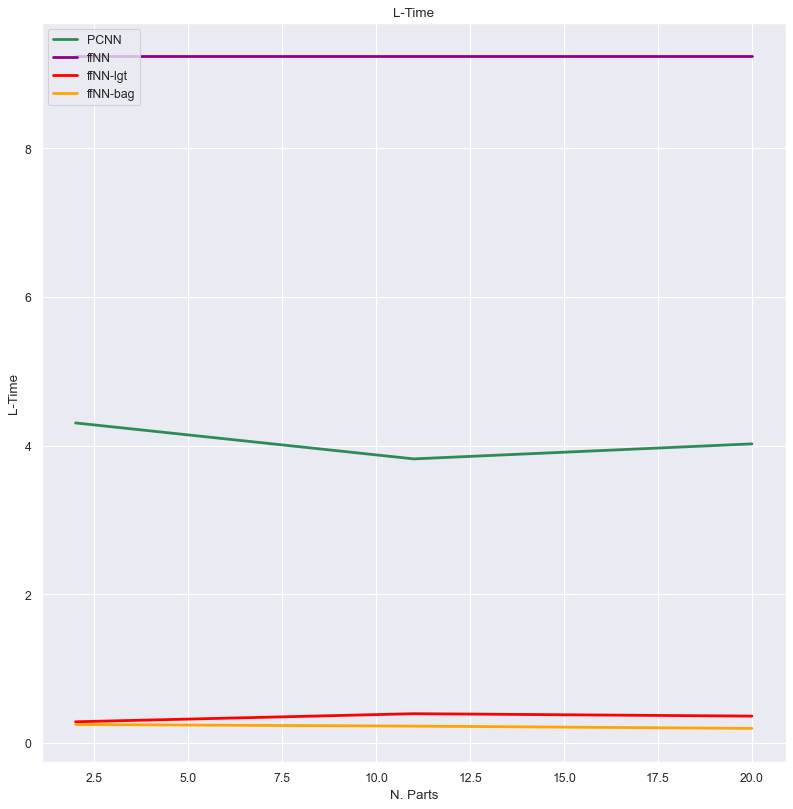

In [19]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("L-Time")
plt.xlabel("N. Parts")
plt.ylabel("L-Time")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_Times,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_times_ffNN_plot,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_time_PCNN_lgt,
         label = 'ffNN-lgt',
         color='red',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_time_PCNN_bag,
         label = 'ffNN-bag',
         color='orange',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_L_Time___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# P-Times

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


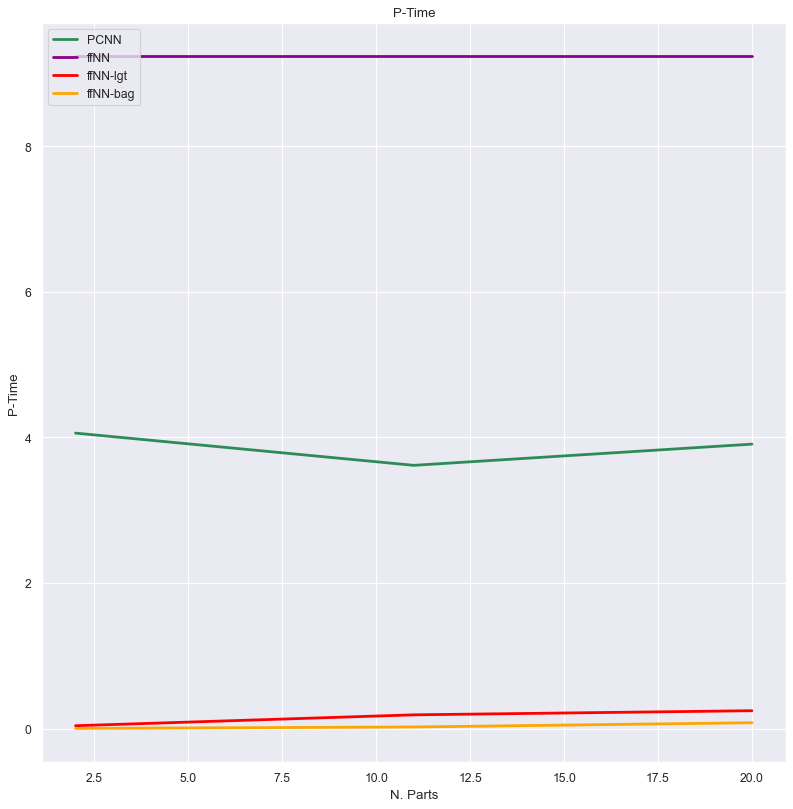

In [20]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("P-Time")
plt.xlabel("N. Parts")
plt.ylabel("P-Time")

# Generate Plots #
#----------------#
# Plot Signal
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_Times,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_times_ffNN_plot,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_time_PCNN_lgt,
         label = 'ffNN-lgt',
         color='red',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_time_PCNN_bag,
         label = 'ffNN-bag',
         color='orange',
         linewidth=2.5)
plt.legend(loc="upper left")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_P_Time___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

## N-Params

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


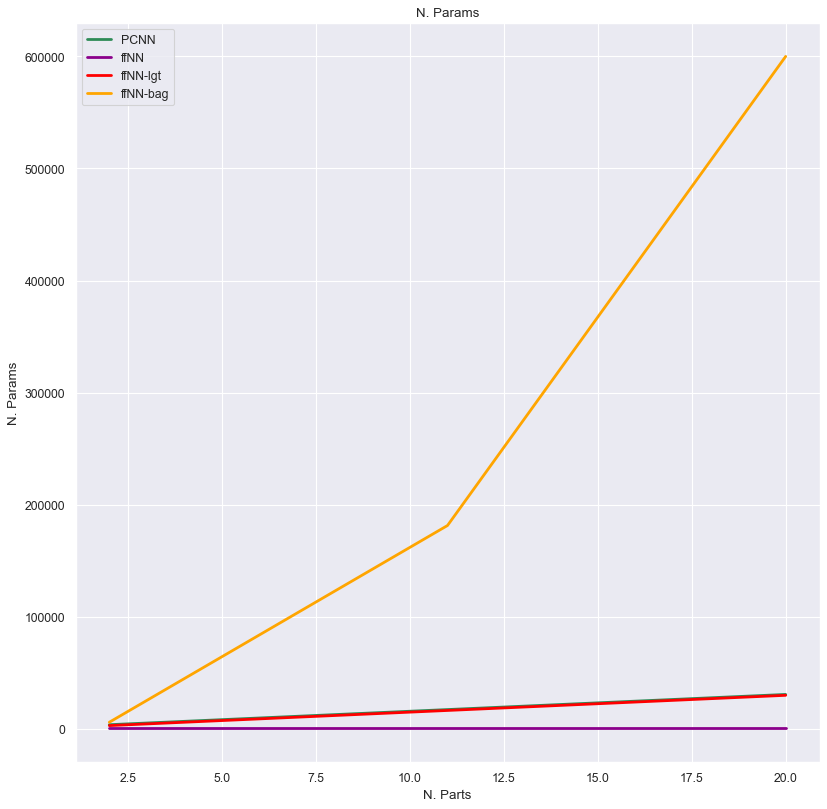

In [21]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("N. Params")
plt.xlabel("N. Parts")
plt.ylabel("N. Params")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_Params,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_params_PCNN_logistic_hist,
         label = 'ffNN-lgt',
         color='red',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_params_PCNN_ffNN_bag,
         label = 'ffNN-bag',
         color='orange',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_N_Params___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# Number of Active Neurons Per Input

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


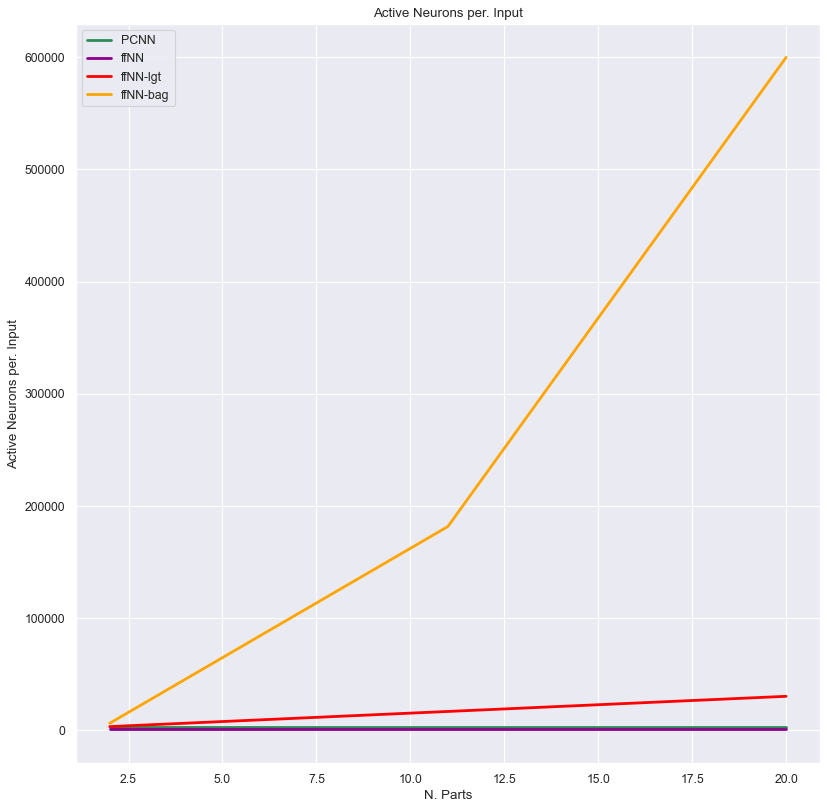

In [22]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("Active Neurons per. Input")
plt.xlabel("N. Parts")
plt.ylabel("Active Neurons per. Input")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_per_input,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_params_PCNN_logistic_hist_per_input,
         label = 'ffNN-lgt',
         color='red',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_params_PCNN_ffNN_bag_per_input,
         label = 'ffNN-bag',
         color='orange',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_Active_Neurons_per_input___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# Mean Widths for Sub-Pattern Networks

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


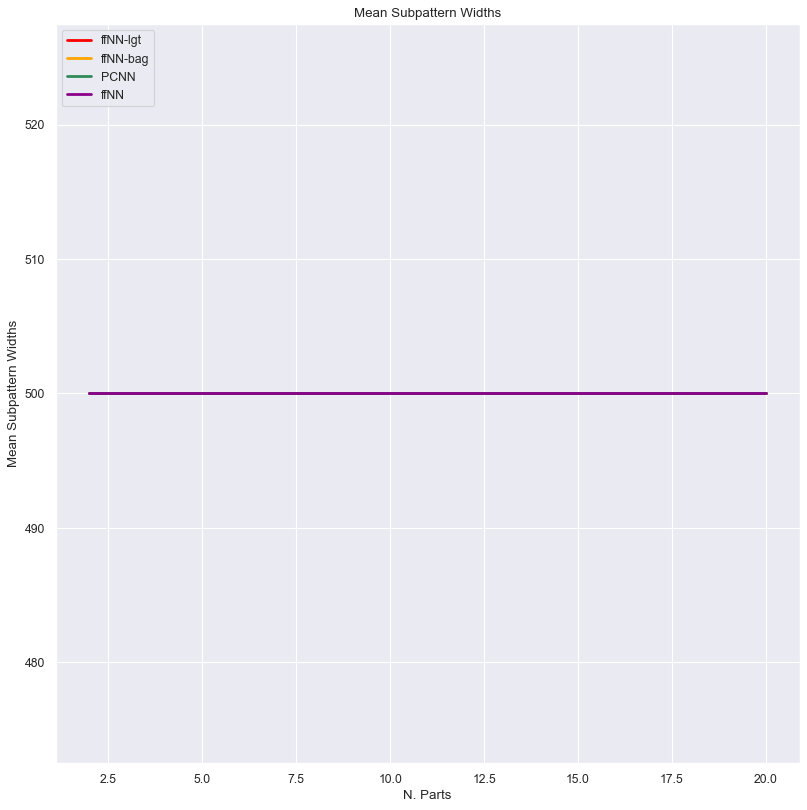

In [23]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("Mean Subpattern Widths")
plt.xlabel("N. Parts")
plt.ylabel("Mean Subpattern Widths")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         mean_subpattern_widths_hist,
         label = 'ffNN-lgt',
         color='red',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         mean_subpattern_widths_hist,
         label = 'ffNN-bag',
         color='orange',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         mean_subpattern_widths_hist,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         mean_subpattern_widths_hist,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_Mean_Widths___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# Table(s)

In [24]:
for j in range(3):
    print('---------------------')
print('Prediction Metric(s)')
for j in range(3):
    print('---------------------')
print(predictive_performance_test)
for j in range(3):
    print(' ')
for j in range(3):
    print('---------------------')
print('Model Complexitie(s)')
for j in range(3):
    print('---------------------')
print(training_times_In_Line)
print(training_times_Parallel)

---------------------
---------------------
---------------------
Prediction Metric(s)
---------------------
---------------------
---------------------
               MAE       MSE        MAPE
ffNN      1.224651  5.713616   35.210818
GBRF      0.437993  0.371069   48.102996
ffNN-bag  1.447395  3.382185  123.561714
ffNN-lgt  0.509258  2.239183  127.247676
PCNN      1.196116  5.860450   33.709373
 
 
 
---------------------
---------------------
---------------------
Model Complexitie(s)
---------------------
---------------------
---------------------
                   ffNN   GBRF  ffNN-Bag  ffNN-log   PCNN
In-Line (L-Time)  4.304  1.213     0.196     0.361  4.023
                  ffNN GBRF  ffNN-Bag  ffNN-log   PCNN
Parallel (P-Time)    -    -     0.196     0.361  4.023


---

---

---

# Fin

---

---

---